In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
#load data
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
with open(os.path.join(full_folder_path,"Aug7_1mil.pkl"), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
print(len(clean_data_dict['2_phi']))

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])

dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [3]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'charge_2', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'charge_3', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'], 
    ['deltaphi_13', 'deltaeta_13', 'deltaR_13', 'mt_13', 'norm_mt_13'], 
    ['deltaphi_23', 'deltaeta_23', 'deltaR_23', 'mt_23', 'norm_mt_23']
]
# output features: deltaphi, deltaeta, deltaR, m_t,  norm_mt, mass, pt, eta , phi*(maybe dont use),  px, py, pz, energy
labels = {}
for edge, features in zip(pair_order, used_labels2):
    labels[edge] = {feature: data_dict[feature] for feature in features if feature in data_dict}

input_data = {}
for particle, features in zip(input_data_particle_order, input_data_names_ordered):
    input_data[particle] = {feature: data_dict[feature] for feature in features if feature in data_dict}


In [4]:
scalers = {}

for particle, features in zip(input_data_particle_order, input_data_names_ordered):
    for feature in features:
        if feature in data_dict_np:
            scaler = StandardScaler()
            data = data_dict_np[feature].reshape(-1, 1)
            scaler.fit(data)
            data_dict_np[feature] = scaler.transform(data).flatten()
            scalers[(particle, feature)] = scaler

for edge, features in zip(pair_order, used_labels2):
    for feature in features:
        if feature in data_dict_np:
            scaler = StandardScaler()
            data = data_dict_np[feature].reshape(-1, 1)
            scaler.fit(data)
            data_dict_np[feature] = scaler.transform(data).flatten()
            scalers[(edge, feature)] = scaler

for particle, features in zip(input_data_particle_order, input_data_names_ordered):
    input_data[particle] = {feature: data_dict_np[feature] for feature in features if feature in data_dict_np}

for edge, features in zip(pair_order, used_labels2):
    labels[edge] = {feature: data_dict_np[feature] for feature in features if feature in data_dict_np}


In [5]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PairDataset(Dataset):
    def __init__(self, pairs_data, pairs_labels):
        self.pairs_data = pairs_data
        self.pairs_labels = pairs_labels

    def __len__(self):
        return self.pairs_data.size(2)
    def __getitem__(self, idx):
        return self.pairs_data[:, :, idx], self.pairs_labels[:, :, idx]



In [6]:

lepton_labels=['1_2', '1_3', '2_3']
lepton_label_dict= {key: labels[key] for key in lepton_labels}

input_leptons=['1', '2', '3']
input_lepton_dict = {key: input_data[key] for key in input_leptons}

print(lepton_label_dict.keys())
print(lepton_label_dict['1_2'].keys())
print(input_lepton_dict.keys())
print(input_lepton_dict['1'].keys())
print(len(input_lepton_dict['1']['pt_1']))

i_3d_1=list(input_lepton_dict.keys())
i_3d_2=list(input_lepton_dict[i_3d_1[0]].keys())

shape = (len(i_3d_1),len(i_3d_2), len(input_lepton_dict[i_3d_1[0]][i_3d_2[0]]))
input_lepton_3d=np.empty(shape, dtype=float)

for i, k1 in enumerate(i_3d_1):
    for j, k2 in enumerate(i_3d_2):
        
        currfeat=input_data_names_ordered[1+i][j]
        
        input_lepton_3d[i,j,:]=input_lepton_dict[k1][currfeat]

print("input shape: ", input_lepton_3d.shape)
numevents=len(lepton_label_dict['1_2']['deltaphi_12'])

o_3d_1=list(lepton_label_dict.keys())
shape_output=(len(o_3d_1),len(lepton_label_dict[o_3d_1[0]]),numevents)
output_lepton_3d=np.empty(shape_output, dtype=float)
for i in range(len(o_3d_1)):
    for j in range(len(lepton_label_dict[o_3d_1[i]])):
        currfeat=used_labels2[i+3][j]
        # print(o_3d_1[i], currfeat)
        output_lepton_3d[i,j,:]=lepton_label_dict[o_3d_1[i]][currfeat]

print("output shape: ", output_lepton_3d.shape)

dict_keys(['1_2', '1_3', '2_3'])
dict_keys(['deltaphi_12', 'deltaeta_12', 'deltaR_12', 'mt_12', 'norm_mt_12'])
dict_keys(['1', '2', '3'])
dict_keys(['1_phi', 'charge_1', 'pt_1', 'eta_1', 'mass_1'])
568554
input shape:  (3, 5, 568554)
output shape:  (3, 5, 568554)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

input_data = torch.tensor(input_lepton_3d, dtype=torch.float32)
labels_data = torch.tensor(output_lepton_3d, dtype=torch.float32)

pairs_data = []
pairs_labels = []

pairs_order = ['1_2', '1_3', '2_3']
pairs_mapping = {(0,1): '1_2', (1,0): '1_2', (0,2): '1_3', (2,0): '1_3', (1,2): '2_3', (2,1): '2_3'}

for (i, j) in permutations(range(3), 2): 
    concatenated_data = torch.cat([input_data[i], input_data[j]], dim=0) 
    pairs_data.append(concatenated_data)
    # print(concatenated_data.shape)
    # print(pairs_mapping[(i, j)])

    pair_label_idx = pairs_order.index(pairs_mapping[(i, j)])
    pairs_labels.append(labels_data[pair_label_idx])

pairs_data = torch.stack(pairs_data)  
pairs_labels = torch.stack(pairs_labels)  

pairs_data = pairs_data.to(device)
pairs_labels = pairs_labels.to(device)

print("pairs data shape: ", pairs_data.shape)
print("pairs labels shape: ", pairs_labels.shape)


cuda:0
pairs data shape:  torch.Size([6, 10, 568554])
pairs labels shape:  torch.Size([6, 5, 568554])


In [8]:
# all_data = [pairs_data[:, :, i] for i in range(pairs_data.shape[2])]
# all_labels = [pairs_labels[:, :, i] for i in range(pairs_labels.shape[2])]

# train_data, val_data, train_labels, val_labels = train_test_split(all_data, all_labels, test_size=0.2)

# train_dataset = PairDataset(torch.stack(train_data), torch.stack(train_labels))
# val_dataset = PairDataset(torch.stack(val_data), torch.stack(val_labels))

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


train_data_list = []
val_data_list = []
test_data_list = []
train_labels_list = []
val_labels_list = []
test_labels_list = []

for pair_idx in range(6):
    pair_data = pairs_data[pair_idx]
    pair_labels = pairs_labels[pair_idx]
    
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(pair_data.T, pair_labels.T, test_size=0.3)
    
    # Further split train+val into train and val
    train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2)
    
    # Convert to PyTorch tensors and append to lists
    train_data_list.append(torch.tensor(train_data))
    val_data_list.append(torch.tensor(val_data))
    test_data_list.append(torch.tensor(test_data))
    train_labels_list.append(torch.tensor(train_labels))
    val_labels_list.append(torch.tensor(val_labels))
    test_labels_list.append(torch.tensor(test_labels))





/tmp/ddemler/ipykernel_21359/3508986009.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_list.append(torch.tensor(train_data))
/tmp/ddemler/ipykernel_21359/3508986009.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data_list.append(torch.tensor(val_data))
/tmp/ddemler/ipykernel_21359/3508986009.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_list.append(torch.tensor(test_data))
/tmp/ddemler/ipykernel_21359/3508986009.py:33: UserWarning: To copy construct from a tensor, it is recommended to use source

In [9]:
batch_size = 128
# dataset = PairDataset(pairs_data, pairs_labels)


In [10]:
class KinematicNet(nn.Module):
    def __init__(self):
        super(KinematicNet, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 200)
        self.fc3 = nn.Linear(200, 128)
        self.fc4 = nn.Linear(128, 5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

model = KinematicNet()
model.to(device)



KinematicNet(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=5, bias=True)
)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_epochs = 500

for epoch in tqdm(range(num_epochs), desc="Epochs", leave=False, position=0, disable=True):
    

    model.train()
    train_loss = 0.0
    for pair_idx in range(6):
        train_data = train_data_list[pair_idx].to(device)
        train_labels = train_labels_list[pair_idx].to(device)

        y_pred = model(train_data)
        loss = loss_fn(y_pred, train_labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= 6 


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for pair_idx in range(6):
            val_data = val_data_list[pair_idx].to(device)
            val_labels = val_labels_list[pair_idx].to(device)

            y_pred = model(val_data)
            loss = loss_fn(y_pred, val_labels)
            val_loss += loss.item()
    
    val_loss /= 6  

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/500], Train Loss: 0.2692, Val Loss: 0.0974
Epoch [2/500], Train Loss: 0.1083, Val Loss: 0.0420
Epoch [3/500], Train Loss: 0.0554, Val Loss: 0.0423
Epoch [4/500], Train Loss: 0.0342, Val Loss: 0.0369
Epoch [5/500], Train Loss: 0.0224, Val Loss: 0.0288
Epoch [6/500], Train Loss: 0.0180, Val Loss: 0.0205
Epoch [7/500], Train Loss: 0.0138, Val Loss: 0.0155
Epoch [8/500], Train Loss: 0.0120, Val Loss: 0.0121
Epoch [9/500], Train Loss: 0.0100, Val Loss: 0.0105
Epoch [10/500], Train Loss: 0.0094, Val Loss: 0.0092
Epoch [11/500], Train Loss: 0.0086, Val Loss: 0.0086
Epoch [12/500], Train Loss: 0.0084, Val Loss: 0.0081
Epoch [13/500], Train Loss: 0.0080, Val Loss: 0.0079
Epoch [14/500], Train Loss: 0.0079, Val Loss: 0.0079
Epoch [15/500], Train Loss: 0.0079, Val Loss: 0.0079
Epoch [16/500], Train Loss: 0.0077, Val Loss: 0.0078
Epoch [17/500], Train Loss: 0.0077, Val Loss: 0.0078
Epoch [18/500], Train Loss: 0.0077, Val Loss: 0.0078
Epoch [19/500], Train Loss: 0.0076, Val Loss: 0.0078
Ep

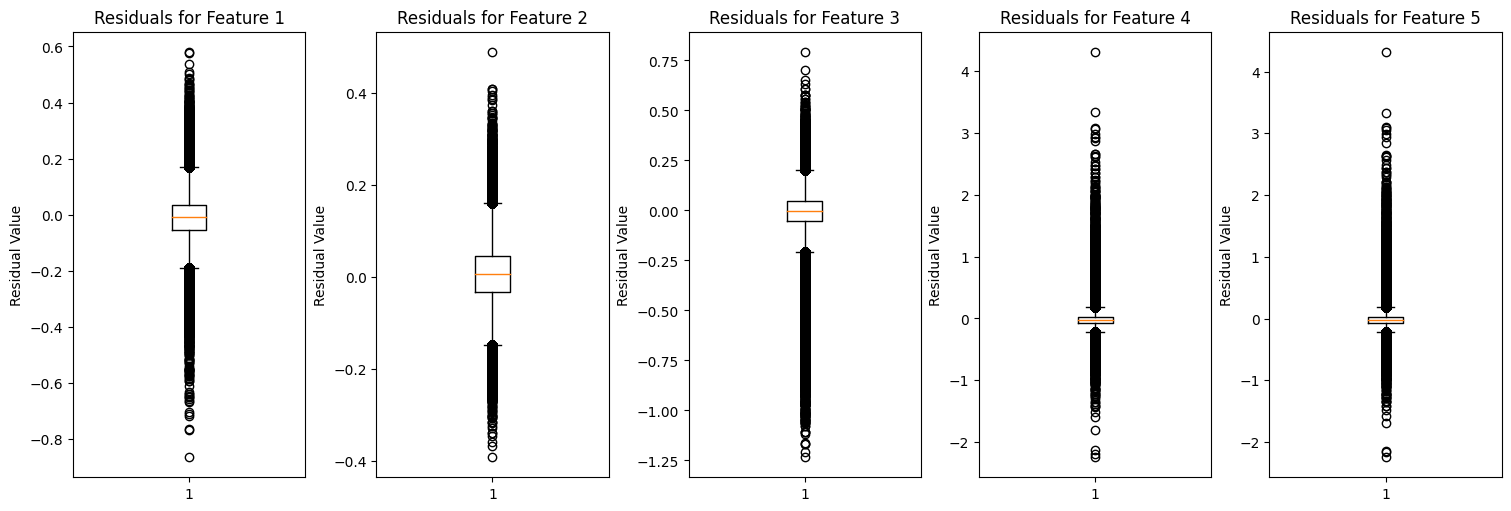

In [12]:

num_features = 5 

residuals = [[] for _ in range(num_features)]

model.eval()
with torch.no_grad():
    for pair_idx in range(6):
        test_data = test_data_list[pair_idx].to(device)
        test_labels = test_labels_list[pair_idx].to(device)
        
        y_pred = model(test_data)
        
        residuals_pair = y_pred.cpu() - test_labels.cpu()
        
        for i in range(num_features):
            residuals[i].append(residuals_pair[:, i])

residuals = [torch.cat(residual_list, dim=0) for residual_list in residuals]

fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5), constrained_layout=True)
for i, ax in enumerate(axes):
    ax.boxplot(residuals[i].numpy())
    ax.set_title(f'Residuals for Feature {i+1}')
    ax.set_ylabel('Residual Value')
plt.show()


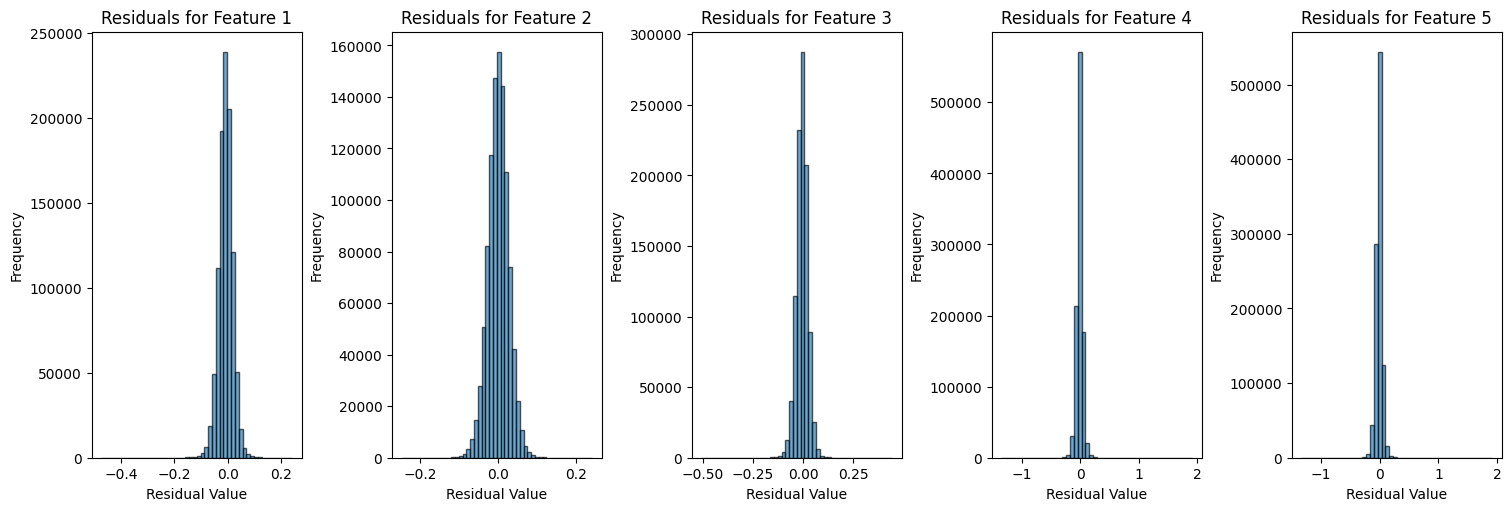

In [15]:
import matplotlib.pyplot as plt
feature=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt']
num_features = 5 

residuals = [[] for _ in range(num_features)]

model.eval()
with torch.no_grad():
    for pair_idx in range(6):
        test_data = test_data_list[pair_idx].to(device)
        test_labels = test_labels_list[pair_idx].to(device)
        
        y_pred = model(test_data)
        

        residuals_pair = y_pred.cpu() - test_labels.cpu()
        

        for i in range(num_features):
            residuals[i].append(residuals_pair[:, i])


residuals = [torch.cat(residual_list, dim=0) for residual_list in residuals]


fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5), constrained_layout=True)
for i, ax in enumerate(axes):
    ax.hist(residuals[i].numpy(), bins=50, edgecolor='k', alpha=0.65)
    ax.set_title(f'Residuals for Feature {i+1}')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
plt.show()
